In [11]:
%matplotlib inline
import cosima_cookbook as cc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, shiftgrid
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
import cartopy
import cartopy.crs as ccrs
import pandas as pd
import copy
import math
from collections import OrderedDict
import IPython.display
# import seaborn as sns
from glob import glob
#import scipy as sp
#import scipy.interpolate
#import scipy.ndimage
from tqdm import tqdm_notebook
import IPython.display
import cmocean as cm
from scipy.io import loadmat
from dask.distributed import Client
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.ticker as mticker
import warnings
warnings.filterwarnings('ignore')
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
import cftime
import matplotlib
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

Available exptdata keys:  ['1deg', '025deg', '025deg_abs', '01deg']


In [7]:
figdir = ''
NOSYNC = 'NOSYNC/' # where to save figs we don't want to sync
if not os.path.exists(NOSYNC):
    os.makedirs(NOSYNC)
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    #plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [27]:
plot_labels=['(a) ','(b) ','(c) ','(d)']
land_50m = cft.NaturalEarthFeature('physical', 'land', '110m',
                                        edgecolor='black',
                                        facecolor='gray',
                                        linewidth=0.5)
font={'family':'normal',
     'weight':'bold',
     'size':16}
matplotlib.rc('font',**font)

In [21]:
WBC=OrderedDict([
    ('eac', {'region':[140-360,220-360,-55,-20], 'x':slice(140-360,220-360),
                    'y': slice(-55,-20)}),
    ('gs',  {'region':[-82,-62,22,46], 'x':slice(-82,-62),
                    'y': slice(22,46)}),
    ('kc',  {'region':[130-360,155-360,28,45], 'x':slice(130-360,155-360),
                    'y': slice(28,45)})
])

In [9]:
session = cc.database.create_session()

In [5]:
#exptdict = OrderedDict([
#    ('025deg', {'model':'access-om2-025', 'expt':'025deg_jra55v13_iaf_gmredi6',
#                    'desc': 'ACCESS-OM2-025','n_files':-34,
#                    'time_units':'days since 1718-01-01','offset':-87658}),
#    ('025deg_abs',  {'model':'access-om2-025',  'expt':'025deg_jra55v13_iaf_gmredi6_abswind',
#                'desc': 'ACCESS-OM2-025-abswind','n_files':-29,
#                    'time_units':'days since 1718-01-01','offset':-87658})
#])

In [14]:
time=slice('1960-01-01','2018-01-01')

In [17]:
def get_gyre_psi(ekey,time):
    
    expt = exptdata.exptdict[ekey]['expt']
    n_files = exptdata.exptdict[ekey]['n_files']
    offset = exptdata.exptdict[ekey]['offset']
    
    cntrl_tx_trans = cc.querying.getvar(expt,'tx_trans_int_z',session,
                                        n=n_files, offset=offset).sel(time=time).mean('time')
                                        #.sel(time=slice(tstart,tend))\
    # convert from kg/s to Sv, assuming typical density of 1036kg/m^3 (underestimates deep ocean)
    cntrl_psi = cntrl_tx_trans.cumsum('yt_ocean')/1e6/1036
    #now find DP transport to subtract for the NAtl psi - see Rong
    cntrl_dp_ts = cntrl_psi.sel(xu_ocean=0,method='nearest').sel(yt_ocean=20,method='nearest')
    gyre_psi = -cntrl_psi+cntrl_dp_ts

    # write to disk
#     gyre_psi.to_netcdf(NOSYNC + expt + '_gyre_psi_1998-2017.nc')
    
    return gyre_psi

In [18]:
gyre_psi=get_gyre_psi('1deg',time)

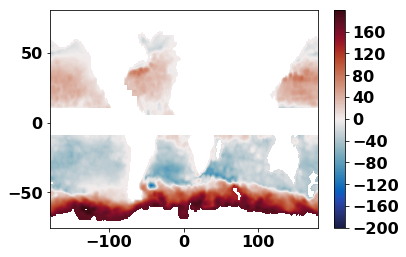

In [30]:
data=loadmat('/g/data3/hh5/tmp/cosima/observations/original/psi_barotropic.mat')
lon = data['lon_p'][0,:]
lat = data['lat_p'][0,:]
psi = data['psi']/1e6 # in Sv
plt.contourf(lon,lat,psi,levels=np.arange(-200,200),cmap = cm.cm.balance)
plt.colorbar()

Text(0,0.5,'Transport (Sv)')

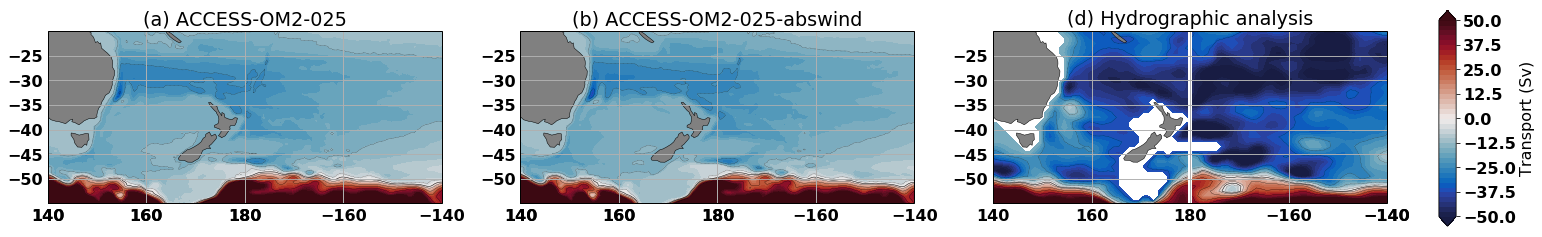

In [32]:
# EAC Region
warnings.filterwarnings('ignore')
eac=WBC['eac']['region']
x_eac=WBC['eac']['x']
y_eac=WBC['eac']['y']
plt.figure(figsize=(24,6))
clev = np.arange(-50,50.01,2.5)
clev2 = np.arange(-35,35.01,10)

for i, ekey in enumerate(abs_rel):
    expt = exptdata.exptdict[ekey]['expt']
    gyre_psi = get_gyre_psi(ekey,time)
    ax = plt.subplot(1,3,i+1,projection=ccrs.PlateCarree(central_longitude=180))
    ax.add_feature(land_50m)
    ax.set_extent(eac, crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=False, xlocs=np.arange(x_eac.start,x_eac.stop+1,20),
                      ylocs=np.arange(y_eac.start,y_eac.stop+1,5))
    gl = ax.gridlines(draw_labels=True, xlocs=np.arange(x_eac.start,x_eac.stop+1,20)+360,ylocs=[y_eac.start,y_eac.stop])
    gl.xlabels_top = False
    gl = ax.gridlines(draw_labels=True, xlocs=[140,160,180,-160,-140],ylocs=np.arange(y_eac.start,y_eac.stop+1,5))
    gl.xlabels_top = False
    gl.ylabels_right = False
    p1=gyre_psi.plot.contourf(cmap=cm.cm.balance, levels=clev, extend='both', 
                              add_colorbar=False, transform=ccrs.PlateCarree()) 
    gyre_psi.plot.contour(levels=clev2,colors='k',linewidths=0.25,transform=ccrs.PlateCarree())
    gyre_psi.plot.contour(levels=[0.0,],colors='k',linewidths=0.5,transform=ccrs.PlateCarree())
    plt.title(plot_labels[i]+exptdict[ekey]['desc'])


ax = plt.subplot(1,3,3,projection=ccrs.PlateCarree(central_longitude=180))
ax.add_feature(land_50m)
ax.set_extent(eac, crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=False, xlocs=np.arange(x_eac.start,x_eac.stop+1,20),ylocs=np.arange(y_eac.start,y_eac.stop+1,5))
gl = ax.gridlines(draw_labels=True, xlocs=[140,160,180,-160,-140],ylocs=[y_eac.start,y_eac.stop])
gl.xlabels_top = False
gl = ax.gridlines(draw_labels=True, xlocs=[x_eac.start,x_eac.stop],ylocs=np.arange(y_eac.start,y_eac.stop+1,5))
gl.xlabels_top = False
gl.ylabels_right = False
p1=plt.contourf(lon,lat,psi,cmap=cm.cm.balance, levels=clev, extend='both', 
                transform=ccrs.PlateCarree()) 
plt.contour(lon,lat,psi,levels=clev2,colors='k',linewidths=0.25,transform=ccrs.PlateCarree())
plt.contour(lon,lat,psi,levels=[0.0,],colors='k',linewidths=0.5,transform=ccrs.PlateCarree())
plt.title('(d) Hydrographic analysis')
    
ax3 = plt.axes([0.93,0.25,0.01,0.5])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Transport (Sv)')
#savefigure('eac_barotropic_streamfunctions')

Text(0,0.5,'Transport (Sv)')

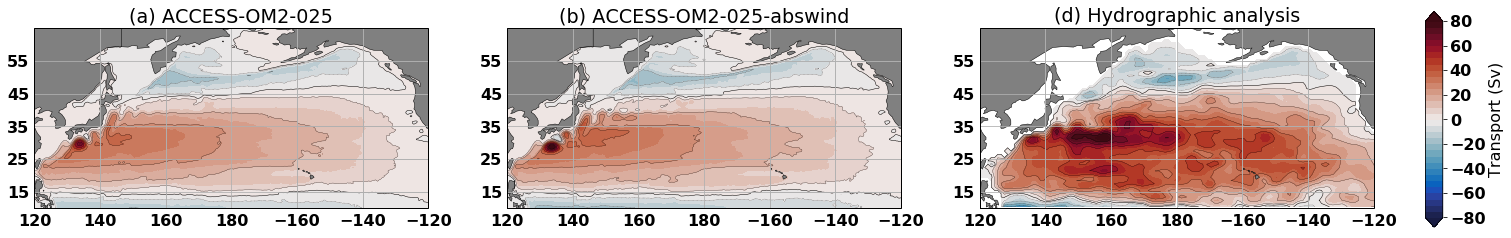

In [34]:
# Kuroshio Region
warnings.filterwarnings('ignore')
plt.figure(figsize=(24,6))
clev = np.arange(-80,80.01,5)
clev2 = np.arange(-75,75.01,10)

for i, ekey in enumerate(abs_rel):
    expt = exptdata.exptdict[ekey]['expt']
    gyre_psi = get_gyre_psi(ekey,time)
    ax = plt.subplot(1,3,i+1,projection=ccrs.PlateCarree(central_longitude=180))
    ax.add_feature(land_50m)
    ax.set_extent([-240, -120, 10, 65], crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=False, xlocs=[-240, -220, -200, -180, -160, -140, -120],ylocs=[10, 15, 25, 35, 45, 55, 65])
    gl = ax.gridlines(draw_labels=True, xlocs=[120, 140, 160, 180],ylocs=[10,65])
    gl.xlabels_top = False
    gl = ax.gridlines(draw_labels=True, xlocs=[-160, -140, -120],ylocs=[10, 15, 25, 35, 45, 55, 65])
    gl.xlabels_top = False
    gl.ylabels_right = False
    
    p1=gyre_psi.plot.contourf(cmap=cm.cm.balance, levels=clev, extend='both', 
                              add_colorbar=False, transform=ccrs.PlateCarree()) 
    gyre_psi.plot.contour(levels=clev2,colors='k',linewidths=0.25,transform=ccrs.PlateCarree())
    gyre_psi.plot.contour(levels=[0.0,],colors='k',linewidths=0.5,transform=ccrs.PlateCarree())
    plt.title(plot_labels[i]+exptdict[ekey]['desc'])


ax = plt.subplot(1,3,3,projection=ccrs.PlateCarree(central_longitude=180))
ax.add_feature(land_50m)
ax.set_extent([-240, -120, 10, 65], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=False, xlocs=[-240, -220, -200, -180, -160, -140, -120],ylocs=[10, 15, 25, 35, 45, 55, 65])
gl = ax.gridlines(draw_labels=True, xlocs=[120, 140, 160, 180],ylocs=[10,65])
gl.xlabels_top = False
gl = ax.gridlines(draw_labels=True, xlocs=[-160, -140, -120],ylocs=[10, 15, 25, 35, 45, 55, 65])
gl.xlabels_top = False
gl.ylabels_right = False

p1=plt.contourf(lon,lat,psi,cmap=cm.cm.balance, levels=clev, extend='both', 
                transform=ccrs.PlateCarree()) 
plt.contour(lon,lat,psi,levels=clev2,colors='k',linewidths=0.25,transform=ccrs.PlateCarree())
plt.contour(lon,lat,psi,levels=[0.0,],colors='k',linewidths=0.5,transform=ccrs.PlateCarree())
plt.title('(d) Hydrographic analysis')
    
ax3 = plt.axes([0.93,0.25,0.01,0.5])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Transport (Sv)')
#savefigure('kuroshio_barotropic_streamfunctions')

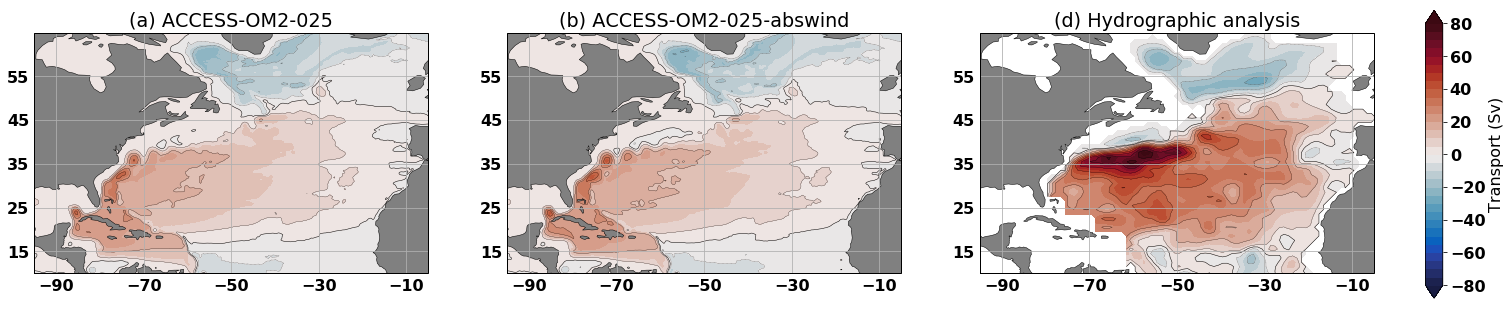

In [36]:
# Gulf Stream Region
warnings.filterwarnings('ignore')
plt.figure(figsize=(24,8))
clev = np.arange(-80,80.01,5)
clev2 = np.arange(-75,75.01,10)

for i, ekey in enumerate(abs_rel):
    expt = exptdata.exptdict[ekey]['expt']
    gyre_psi = get_gyre_psi(ekey,time)
    ax = plt.subplot(1,3,i+1,projection=ccrs.PlateCarree(central_longitude=180))
    ax.add_feature(land_50m)
    ax.set_extent([-95, -5, 10, 65], crs=ccrs.PlateCarree())
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    gl.xlocator = mticker.FixedLocator([-95, -90, -70, -50, -30, -10, -5])
    gl.ylocator = mticker.FixedLocator([10, 15, 25, 35, 45, 55, 65])
    gl.xlabels_top = False
    gl.ylabels_right = False
    
    p1=gyre_psi.plot.contourf(cmap=cm.cm.balance, levels=clev, extend='both', 
                              add_colorbar=False, transform=ccrs.PlateCarree()) 
    gyre_psi.plot.contour(levels=clev2,colors='k',linewidths=0.25,transform=ccrs.PlateCarree())
    gyre_psi.plot.contour(levels=[0.0,],colors='k',linewidths=0.5,transform=ccrs.PlateCarree())
    plt.title(plot_labels[i]+exptdict[ekey]['desc'])


ax = plt.subplot(1,3,3,projection=ccrs.PlateCarree())
ax.add_feature(land_50m)
ax.set_extent([-95, -5, 10, 65], crs=ccrs.PlateCarree())
    
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlocator = mticker.FixedLocator([-95, -90, -70, -50, -30, -10, -5])
gl.ylocator = mticker.FixedLocator([10, 15, 25, 35, 45, 55, 65])
gl.xlabels_top = False
gl.ylabels_right = False
p1=plt.contourf(lon,lat,psi,cmap=cm.cm.balance, levels=clev, extend='both', 
                transform=ccrs.PlateCarree()) 
plt.contour(lon,lat,psi,levels=clev2,colors='k',linewidths=0.25,transform=ccrs.PlateCarree())
plt.contour(lon,lat,psi,levels=[0.0,],colors='k',linewidths=0.5,transform=ccrs.PlateCarree())
plt.title('(d) Hydrographic analysis')
    
ax3 = plt.axes([0.93,0.25,0.01,0.5])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Transport (Sv)')
#savefigure('gulfstream_barotropic_streamfunctions')

Text(0,0.5,'Transport (Sv)')

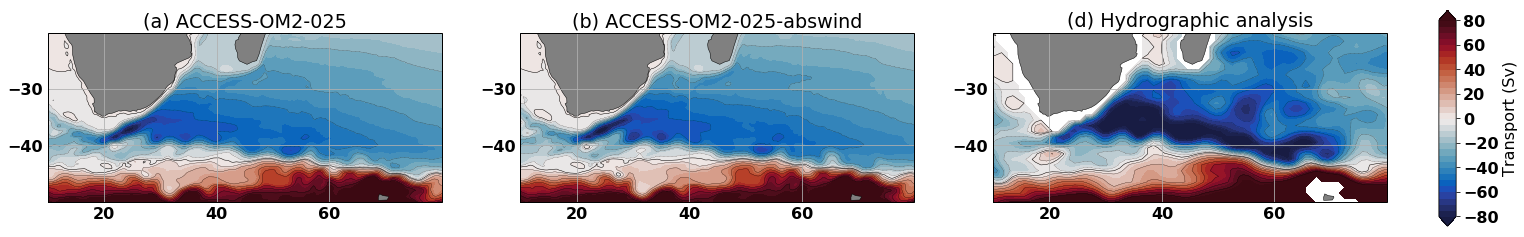

In [37]:
# Agulhas Region
warnings.filterwarnings('ignore')
plt.figure(figsize=(24,6))
clev = np.arange(-80,80.01,5)
clev2 = np.arange(-75,75.01,10)

for i, ekey in enumerate(abs_rel):
    expt = exptdata.exptdict[ekey]['expt']
    gyre_psi = get_gyre_psi(ekey,time)
    ax = plt.subplot(1,3,i+1,projection=ccrs.PlateCarree(central_longitude=180))
    ax.add_feature(land_50m)
    ax.set_extent([10, 80, -50, -20], crs=ccrs.PlateCarree())
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    gl.xlocator = mticker.FixedLocator([10, 20, 40, 60, 80])
    gl.ylocator = mticker.FixedLocator([-50, -40, -30, -20])
    gl.xlabels_top = False
    gl.ylabels_right = False
    
    p1=gyre_psi.plot.contourf(cmap=cm.cm.balance, levels=clev, extend='both', 
                              add_colorbar=False, transform=ccrs.PlateCarree()) 
    gyre_psi.plot.contour(levels=clev2,colors='k',linewidths=0.25,transform=ccrs.PlateCarree())
    gyre_psi.plot.contour(levels=[0.0,],colors='k',linewidths=0.5,transform=ccrs.PlateCarree())
    plt.title(plot_labels[i]+exptdict[ekey]['desc'])


ax = plt.subplot(1,3,3,projection=ccrs.PlateCarree())
ax.add_feature(land_50m)
ax.set_extent([10, 80, -50, -20], crs=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlocator = mticker.FixedLocator([10, 20, 40, 60, 80])
gl.ylocator = mticker.FixedLocator([-50, -40, -30, -20])
gl.xlabels_top = False
gl.ylabels_right = False
    
p1=plt.contourf(lon,lat,psi,cmap=cm.cm.balance, levels=clev, extend='both', 
                transform=ccrs.PlateCarree()) 
plt.contour(lon,lat,psi,levels=clev2,colors='k',linewidths=0.25,transform=ccrs.PlateCarree())
plt.contour(lon,lat,psi,levels=[0.0,],colors='k',linewidths=0.5,transform=ccrs.PlateCarree())
plt.title('(d) Hydrographic analysis')
    
ax3 = plt.axes([0.93,0.25,0.01,0.5])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Transport (Sv)')
#savefigure('agulhas_barotropic_streamfunctions')

Text(0,0.5,'Transport (Sv)')

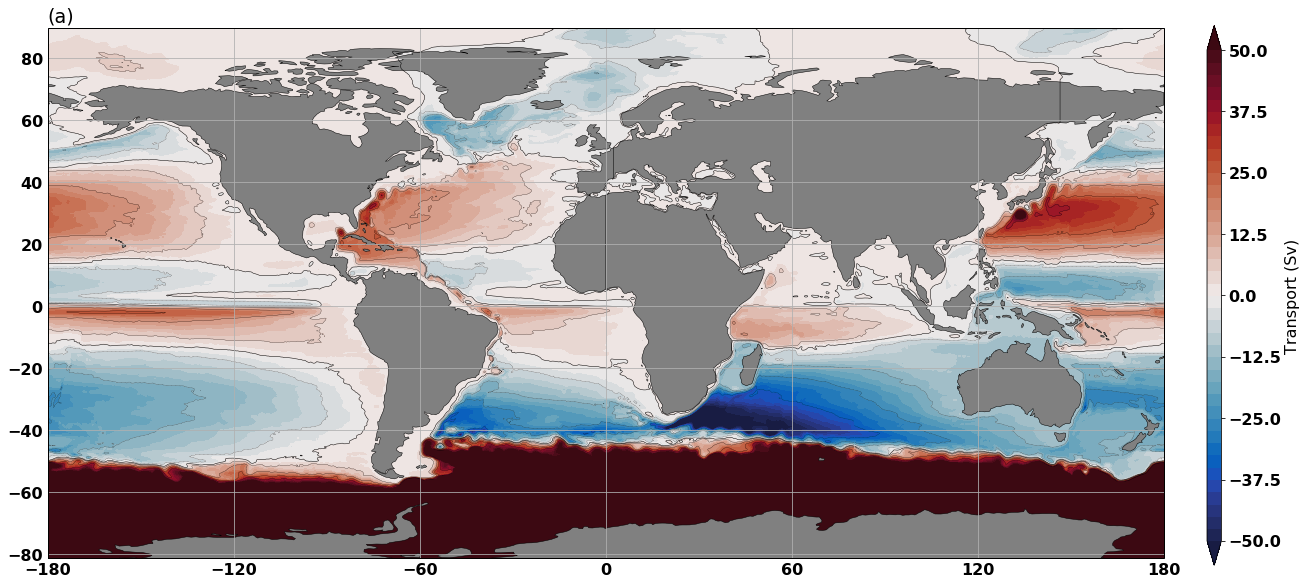

In [39]:
warnings.filterwarnings('ignore')
clev = np.arange(-50,50.01,2.5)
clev2 = np.arange(-35,35.01,10)
fig=plt.figure(figsize=(20,15))
gyre_psi = get_gyre_psi('025deg',time)
ax = plt.subplot(1,1,1,projection=ccrs.PlateCarree())
ax.add_feature(land_50m)
#ax.set_extent([10, 80, -50, -20], crs=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
#gl.xlocator = mticker.FixedLocator([10, 20, 40, 60, 80])
#gl.ylocator = mticker.FixedLocator([-50, -40, -30, -20])
gl.xlabels_top = False
gl.ylabels_right = False

p1=gyre_psi.plot.contourf(cmap=cm.cm.balance, levels=clev, extend='both', 
                          add_colorbar=False, transform=ccrs.PlateCarree()) 
gyre_psi.plot.contour(levels=clev2,colors='k',linewidths=0.25,transform=ccrs.PlateCarree())
gyre_psi.plot.contour(levels=[0.0,],colors='k',linewidths=0.5,transform=ccrs.PlateCarree())
plt.title('')
plt.title('(a)',loc='left')
plt.xlabel('Longitude',fontsize=18)
plt.ylabel('Latitude',fontsize=18)
ax3 = plt.axes([0.93,0.25,0.01,0.5])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Transport (Sv)')
#savefigure('streamfunction_global_025_cb')

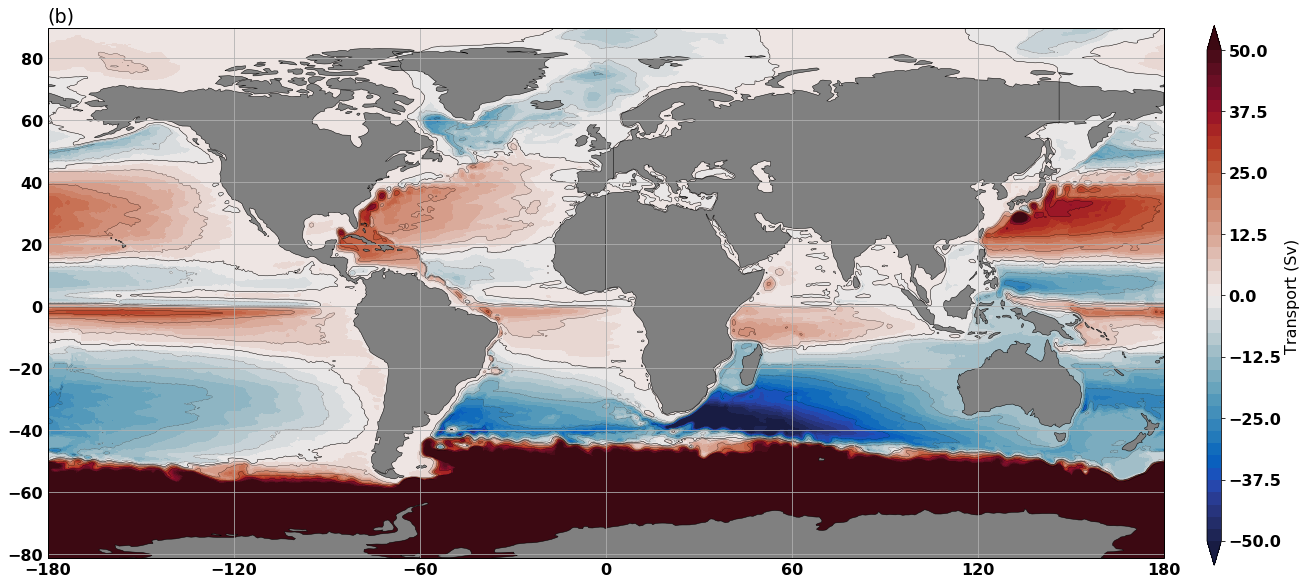

In [40]:
warnings.filterwarnings('ignore')
fig=plt.figure(figsize=(20,15))
gyre_psi = get_gyre_psi('025deg_abs',time)
ax = plt.subplot(1,1,1,projection=ccrs.PlateCarree())
ax.add_feature(land_50m)
#ax.set_extent([10, 80, -50, -20], crs=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
#gl.xlocator = mticker.FixedLocator([10, 20, 40, 60, 80])
#gl.ylocator = mticker.FixedLocator([-50, -40, -30, -20])
gl.xlabels_top = False
gl.ylabels_right = False

p1=gyre_psi.plot.contourf(cmap=cm.cm.balance, levels=clev, extend='both', 
                          add_colorbar=False, transform=ccrs.PlateCarree()) 
gyre_psi.plot.contour(levels=clev2,colors='k',linewidths=0.25,transform=ccrs.PlateCarree())
gyre_psi.plot.contour(levels=[0.0,],colors='k',linewidths=0.5,transform=ccrs.PlateCarree())
plt.title('')
plt.title('(b)',loc='left')
plt.xlabel('Longitude',fontsize=18)
plt.ylabel('Latitude',fontsize=18)
ax3 = plt.axes([0.93,0.25,0.01,0.5])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Transport (Sv)')
#savefigure('streamfunction_global_025abswind_cb')

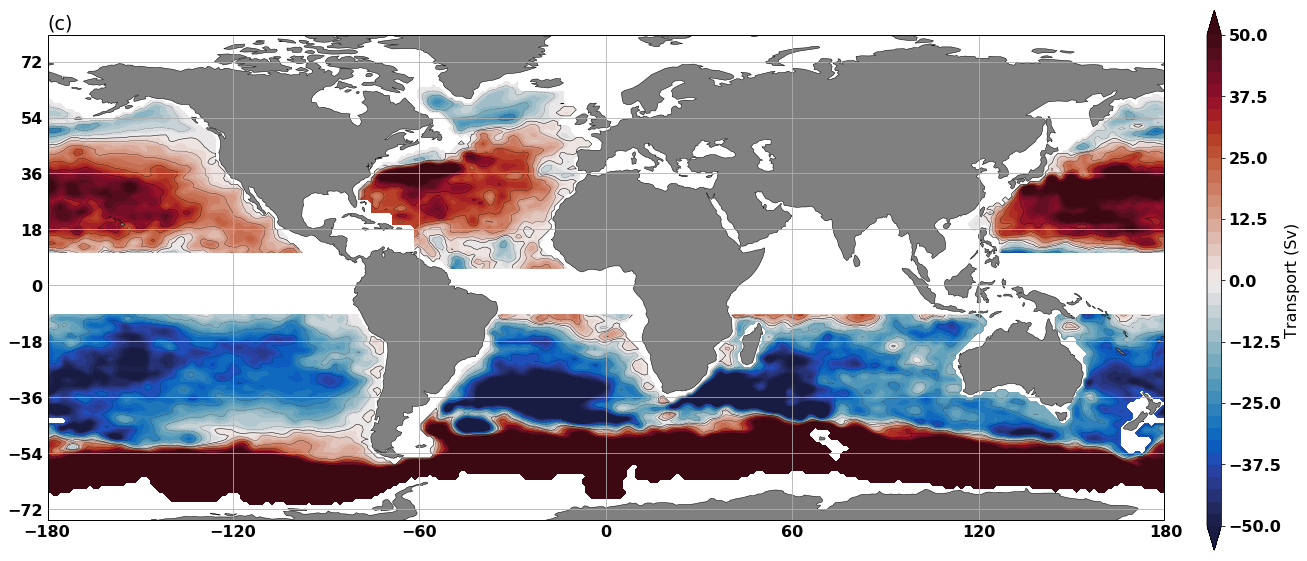

In [41]:
warnings.filterwarnings('ignore')
fig=plt.figure(figsize=(20,15))
ax = plt.subplot(1,1,1,projection=ccrs.PlateCarree())
ax.add_feature(land_50m)
#ax.set_extent([10, 80, -50, -20], crs=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
#gl.xlocator = mticker.FixedLocator([10, 20, 40, 60, 80])
#gl.ylocator = mticker.FixedLocator([-50, -40, -30, -20])
gl.xlabels_top = False
gl.ylabels_right = False
    
p1=plt.contourf(lon,lat,psi,cmap=cm.cm.balance, levels=clev, extend='both',add_colorbar=False,
                transform=ccrs.PlateCarree()) 
plt.contour(lon,lat,psi,levels=clev2,colors='k',linewidths=0.25,transform=ccrs.PlateCarree())
plt.contour(lon,lat,psi,levels=[0.0,],colors='k',linewidths=0.5,transform=ccrs.PlateCarree())
plt.title('')
plt.title('(c)',loc='left')
plt.xlabel('Longitude',fontsize=18)
plt.ylabel('Latitude',fontsize=18)
ax3 = plt.axes([0.93,0.25,0.01,0.5])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Transport (Sv)')
#savefigure('streamfunction_observation')

### Difference

Text(0,0.5,'Transport (Sv)')

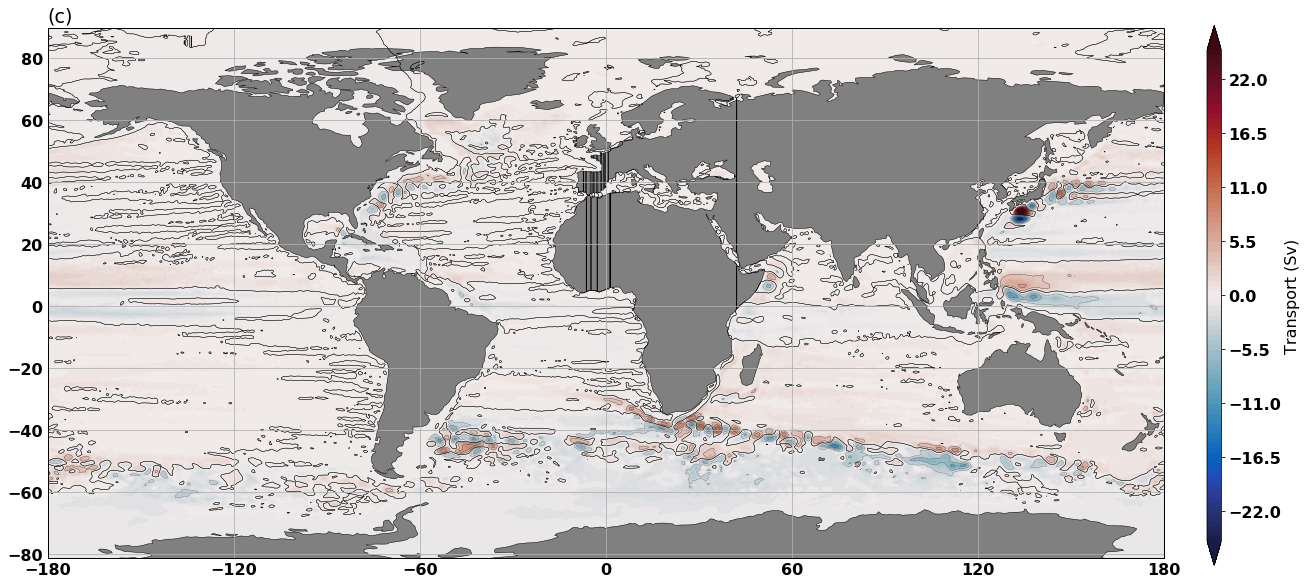

In [42]:
warnings.filterwarnings('ignore')
clev = np.arange(-50,50.01,2.5)
clev1=np.arange(-25,25.1,0.5)
#clev2 = np.arange(-35,35.01,10)
clev2=np.arange(-15,15,3)
fig=plt.figure(figsize=(20,15))
gyre_psi_rel = get_gyre_psi('025deg',time)
gyre_psi_abs = get_gyre_psi('025deg_abs',time)
diff=gyre_psi_rel-gyre_psi_abs
ax = plt.subplot(1,1,1,projection=ccrs.PlateCarree())
ax.add_feature(land_50m)
#ax.set_extent([10, 80, -50, -20], crs=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
#gl.xlocator = mticker.FixedLocator([10, 20, 40, 60, 80])
#gl.ylocator = mticker.FixedLocator([-50, -40, -30, -20])
gl.xlabels_top = False
gl.ylabels_right = False

p1=diff.plot.contourf(cmap=cm.cm.balance, levels=clev1, extend='both', 
                          add_colorbar=False, transform=ccrs.PlateCarree()) 
diff.plot.contour(levels=clev2,colors='k',linewidths=0.25,transform=ccrs.PlateCarree())
diff.plot.contour(levels=[0.0,],colors='k',linewidths=0.5,transform=ccrs.PlateCarree())
plt.title('')
plt.title('(c)',loc='left')
plt.xlabel('Longitude',fontsize=18)
plt.ylabel('Latitude',fontsize=18)
ax3 = plt.axes([0.93,0.25,0.01,0.5])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Transport (Sv)')
#savefigure('BS_diff')

plotting 1 in 4
plotting 2 in 4
plotting 3 in 4
plotting 4 in 4


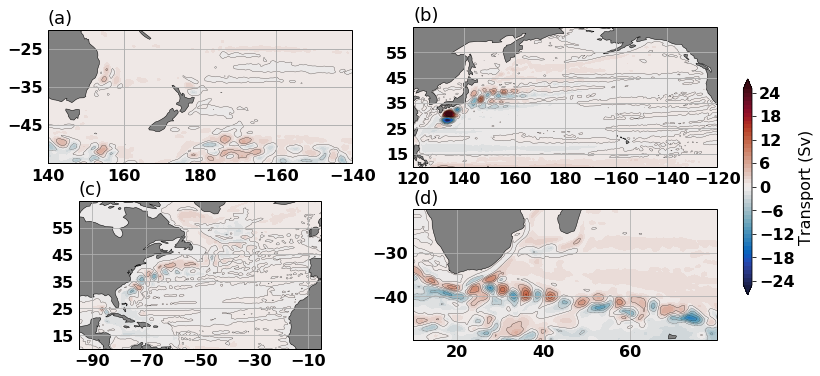

In [18]:
clev3=np.arange(-25,26,1)
clev4=np.arange(-15,15,3)
plt.figure(figsize(12,6))
print('plotting 1 in 4')
ax = plt.subplot(2,2,1,projection=ccrs.PlateCarree(central_longitude=180))
ax.add_feature(land_50m)
ax.set_extent([145, 174, -45, -20], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=False, xlocs=[145, 155, 165, 175],ylocs=[-48, -40, -30, -20, -20])
gl = ax.gridlines(draw_labels=True, xlocs=[140, 160, 180],ylocs=[-55,-20])
gl.xlabels_top = False
gl = ax.gridlines(draw_labels=True, xlocs=[-160, -140],ylocs=[-55, -45, -35, -25, -20])
gl.xlabels_top = False
gl.ylabels_right = False
p1=diff.plot.contourf(cmap=cm.cm.balance, levels=clev3, extend='both', 
                          add_colorbar=False, transform=ccrs.PlateCarree()) 
diff.plot.contour(levels=clev4,colors='k',linewidths=0.25,transform=ccrs.PlateCarree())
plt.title('')
plt.title('(a)',loc='left',fontsize=18)

print('plotting 2 in 4')
ax = plt.subplot(2,2,2,projection=ccrs.PlateCarree(central_longitude=180))
ax.add_feature(land_50m)
ax.set_extent([-240, -120, 10, 65], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=False, xlocs=[-240, -220, -200, -180, -160, -140, -120],ylocs=[10, 15, 25, 35, 45, 55, 65])
gl = ax.gridlines(draw_labels=True, xlocs=[120, 140, 160, 180],ylocs=[10,65])
gl.xlabels_top = False
gl = ax.gridlines(draw_labels=True, xlocs=[-160, -140, -120],ylocs=[10, 15, 25, 35, 45, 55, 65])
gl.xlabels_top = False
gl.ylabels_right = False
p1=diff.plot.contourf(cmap=cm.cm.balance, levels=clev3, extend='both', 
                          add_colorbar=False, transform=ccrs.PlateCarree()) 
diff.plot.contour(levels=clev4,colors='k',linewidths=0.25,transform=ccrs.PlateCarree())
plt.title('')
plt.title('(b)',loc='left',fontsize=18)

print('plotting 3 in 4')
ax = plt.subplot(2,2,3,projection=ccrs.PlateCarree(central_longitude=180))
ax.add_feature(land_50m)
ax.set_extent([-95, -5, 10, 65], crs=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlocator = mticker.FixedLocator([-95, -90, -70, -50, -30, -10, -5])
gl.ylocator = mticker.FixedLocator([10, 15, 25, 35, 45, 55, 65])
gl.xlabels_top = False
gl.ylabels_right = False
p1=diff.plot.contourf(cmap=cm.cm.balance, levels=clev3, extend='both', 
                          add_colorbar=False, transform=ccrs.PlateCarree()) 
diff.plot.contour(levels=clev4,colors='k',linewidths=0.25,transform=ccrs.PlateCarree())
plt.title('')
plt.title('(c)',loc='left',fontsize=18)

print('plotting 4 in 4')
ax = plt.subplot(2,2,4,projection=ccrs.PlateCarree(central_longitude=180))
ax.add_feature(land_50m)
ax.set_extent([10, 80, -50, -20], crs=ccrs.PlateCarree())
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlocator = mticker.FixedLocator([10, 20, 40, 60, 80])
gl.ylocator = mticker.FixedLocator([-50, -40, -30, -20])
gl.xlabels_top = False
gl.ylabels_right = False
p1=diff.plot.contourf(cmap=cm.cm.balance, levels=clev3, extend='both', 
                          add_colorbar=False, transform=ccrs.PlateCarree()) 
diff.plot.contour(levels=clev4,colors='k',linewidths=0.25,transform=ccrs.PlateCarree())
plt.title('')
plt.title('(d)',loc='left',fontsize=18)

ax3 = plt.axes([0.93,0.25,0.01,0.5])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Transport (Sv)')
#plt.xlabel('Longitude',fontsize=16)
#plt.ylabel('Latitude',fontsize=16)
#savefigure('regional_diff')

In [9]:
clev3=np.arange(-30,31,1)
clev4=np.arange(-15,15,3)
clev2 = np.arange(-105,105.01,5)

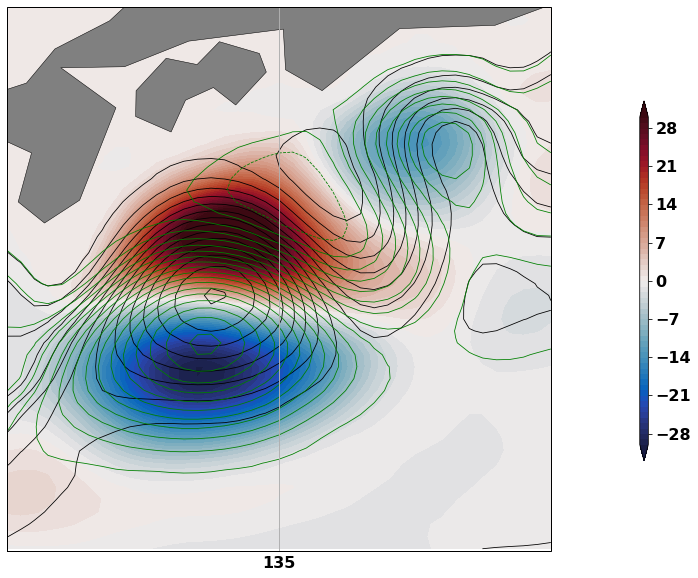

In [13]:
# zoom in to the dipole Kuorshio region
fig=plt.figure(figsize(12,10))
ax = plt.subplot(1,1,1,projection=ccrs.PlateCarree(central_longitude=180))
ax.add_feature(land_50m)
ax.set_extent([130-360, 140-360, 25, 35], crs=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=False, xlocs=[130-360,135-360,140-360],ylocs=[25, 35])
gl = ax.gridlines(draw_labels=True, xlocs=[130,135,140],ylocs=[25,35])
gl.xlabels_top = False
gl.ylabels_right = False
p1=diff.sel(xu_ocean=slice(130-360, 140-360)).sel(yt_ocean=slice(25,35)).plot.contourf(cmap=cm.cm.balance, levels=clev3, extend='both', 
                          add_colorbar=False, transform=ccrs.PlateCarree()) 
gyre_psi_rel.sel(xu_ocean=slice(130-360, 140-360)).sel(yt_ocean=slice(25,35)).plot.contour(levels=clev2,colors='k',linewidths=0.8,transform=ccrs.PlateCarree())
gyre_psi_abs.sel(xu_ocean=slice(130-360, 140-360)).sel(yt_ocean=slice(25,35)).plot.contour(levels=clev2,colors='g',linewidths=0.8,transform=ccrs.PlateCarree())
plt.title('')
ax3 = plt.axes([0.93,0.25,0.01,0.5])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')

plotting 1 in 4
plotting 2 in 4
plotting 3 in 4
plotting 4 in 4


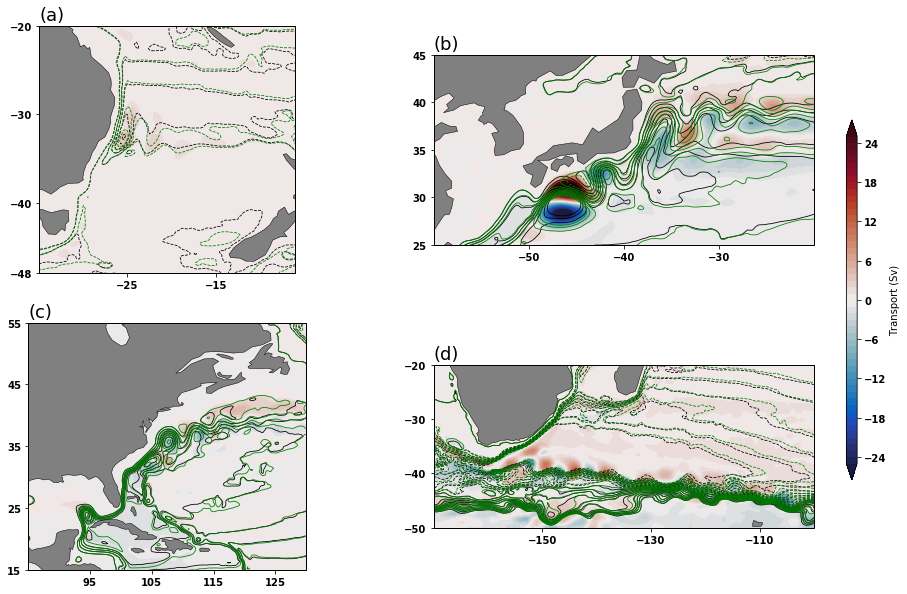

In [20]:
clev3=np.arange(-25,26,1)
clev4=np.arange(-15,15,3)
plt.figure(figsize(15,10))
#fig, axes = plt.subplots(nrows=2, ncols=2)
print('plotting 1 in 4')
ax = plt.subplot(2,2,1,projection=ccrs.PlateCarree(central_longitude=180))
ax.add_feature(land_50m)
ax.set_extent([145, 174, -45, -20], crs=ccrs.PlateCarree())
ax.set_xticks([155,165],crs=ccrs.PlateCarree())
ax.set_yticks([-48,-40,-30,-20],crs=ccrs.PlateCarree())
p1=diff.plot.contourf(cmap=cm.cm.balance, levels=clev3, extend='both', 
                          add_colorbar=False, transform=ccrs.PlateCarree()) 
gyre_psi_rel.plot.contour(levels=clev2,colors='k',linewidths=0.8,transform=ccrs.PlateCarree())
gyre_psi_abs.plot.contour(levels=clev2,colors='g',linewidths=0.8,transform=ccrs.PlateCarree())
plt.xlabel('')
plt.ylabel('')
plt.title('')
plt.title('(a)',loc='left',fontsize=18)

print('plotting 2 in 4')
ax = plt.subplot(2,2,2,projection=ccrs.PlateCarree(central_longitude=180))
ax.add_feature(land_50m)
ax.set_extent([120,160, 25, 45], crs=ccrs.PlateCarree())
ax.set_xticks([130,140,150],crs=ccrs.PlateCarree())
ax.set_yticks([25,30,35,40,45],crs=ccrs.PlateCarree())
p1=diff.plot.contourf(cmap=cm.cm.balance, levels=clev3, extend='both', 
                          add_colorbar=False, transform=ccrs.PlateCarree()) 
gyre_psi_rel.plot.contour(levels=clev2,colors='k',linewidths=0.8,transform=ccrs.PlateCarree())
gyre_psi_abs.plot.contour(levels=clev2,colors='g',linewidths=0.8,transform=ccrs.PlateCarree())
plt.xlabel('')
plt.ylabel('')
plt.title('')
plt.title('(b)',loc='left',fontsize=18)

print('plotting 3 in 4')
ax = plt.subplot(2,2,3,projection=ccrs.PlateCarree(central_longitude=180))
ax.add_feature(land_50m)
ax.set_extent([-95, -50, 15, 55], crs=ccrs.PlateCarree())
ax.set_xticks([-85,-75,-65,-55],crs=ccrs.PlateCarree())
ax.set_yticks([15,25,35,45,55],crs=ccrs.PlateCarree())
p1=diff.plot.contourf(cmap=cm.cm.balance, levels=clev3, extend='both', 
                          add_colorbar=False, transform=ccrs.PlateCarree()) 
gyre_psi_rel.plot.contour(levels=clev2,colors='k',linewidths=0.8,transform=ccrs.PlateCarree())
gyre_psi_abs.plot.contour(levels=clev2,colors='g',linewidths=0.8,transform=ccrs.PlateCarree())
plt.xlabel('')
plt.ylabel('')
plt.title('')
plt.title('(c)',loc='left',fontsize=18)

print('plotting 4 in 4')
ax = plt.subplot(2,2,4,projection=ccrs.PlateCarree(central_longitude=180))
ax.add_feature(land_50m)
ax.set_extent([10, 80, -50, -20], crs=ccrs.PlateCarree())
ax.set_xticks([30,50,70],crs=ccrs.PlateCarree())
ax.set_yticks([-50,-40,-30,-20],crs=ccrs.PlateCarree())
p1=diff.plot.contourf(cmap=cm.cm.balance, levels=clev3, extend='both', 
                          add_colorbar=False, transform=ccrs.PlateCarree()) 
gyre_psi_rel.plot.contour(levels=clev2,colors='k',linewidths=0.8,transform=ccrs.PlateCarree())
gyre_psi_abs.plot.contour(levels=clev2,colors='g',linewidths=0.8,transform=ccrs.PlateCarree())
plt.xlabel('')
plt.ylabel('')
plt.title('')
plt.title('(d)',loc='left',fontsize=18)

ax3 = plt.axes([0.93,0.25,0.01,0.5])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Transport (Sv)')
#plt.xlabel('Longitude',fontsize=16)
#plt.ylabel('Latitude',fontsize=16)
savefigure('regional_diff')